In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import os
import glob
import sys
import pandas as pd
module_path = "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench"
sys.path.insert(0, module_path)
from ipv_workbench.translators import panelizer
from ipv_workbench.utilities import utils, time_utils
from ipv_workbench.translators import mapping_irradiance as ipv_irrad
from ipv_workbench.translators import module_mapping as ipv_mm
from ipv_workbench.sample import dummies
from ipv_workbench.solver import calculations as ipv_calc
from ipv_workbench.solver import simulations_mp as ipv_sim_mp
from ipv_workbench.solver import compile_mp
from ipv_workbench.solver import single_module_mp
from ipv_workbench.solver import topology_solver as ipv_ts

import pickle
from pprint import pprint
import numpy as np
import pvlib
import matplotlib.pyplot as plt
import random
from ipv_workbench.visualize import plots as ipv_plots
import sympy


# Intial Setup of object

In [3]:
PROJECT_FOLDER = "/Users/jmccarty/Desktop/bano_simulations"
BUILDING ="B1391"
pickle_in = os.path.join(PROJECT_FOLDER,"panelizer",BUILDING,"CP_solar_glass_B1391_raw.pickle")
pickle_out = os.path.join(PROJECT_FOLDER,"systems",BUILDING,"CP_solar_glass_B1391_raw.pickle")
po = panelizer.PanelizedObject(pickle_in)
po.set_analysis_period(2000,3200,1)

po.project_setup(PROJECT_FOLDER)

In [31]:
pd.DataFrame({"A":[0,1,2,3,4,5],
              "B":[0,1,2,3,4,5],
              "C":[0,1,2,3,4,5]}).sum(axis=1)

0     0
1     3
2     6
3     9
4    12
5    15
dtype: int64

In [ ]:
panelizer.compile_system(po,write_system=False, mp=False)

In [18]:
from sys import getsizeof
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

get_size(po)

890477568

In [ ]:
pickled_data = pickle.dumps(po)  # returns data as a bytes object
compressed_pickle = blosc.compress(pickled_data)

with open("/Users/jmccarty/Desktop/test.dat", "wb") as f:
    f.write(compressed_pickle)

In [ ]:

# longer runtime (60s) for ~300modules
# TODO parallelize the entire workflow

for surface in po.get_surfaces():
    for string in po.get_strings(surface):
        for module in po.get_modules(surface, string):
            # build parameters for module
            module_dict = po.get_dict_instance([surface,string,module])
            module_details = module_dict['DETAILS']

            parameters = utils.get_cec_data(module_details['cec_key'],file_path=po.CEC_DATA)
            custom_module_data = pd.read_csv(po.MODULE_CELL_DATA,index_col='scenario').loc[module_details['module_type']].to_dict()

            for k,v in custom_module_data.items():
                parameters[k] = v
                
            parameters['N_subcells'] = int(max(parameters['Nsubcell_col'],parameters['Nsubcell_row']))
            for k,v in parameters.items():
                if type(v) is str:
                    try:
                        parameters[k] = float(v)
                    except ValueError:
                        pass
            parameters['n_cols'] = module_details['n_cols']
            parameters['n_rows'] = module_details['n_rows']
            parameters['total_cells'] = parameters['n_cols']*parameters['n_rows']
            # TODO recalculate parameters 
            # cell_area                                                 1.99
            # Wp_m2_cell                                              161.01
            # module_area                                                2.2
            # Wp_m2_module # def deteect_subcells()
            
            # assign subcell counts if present
            actual_cols = parameters['n_cols']
            actual_rows = parameters['n_rows']
            ideal_subcell_col = parameters['Nsubcell_col']
            ideal_subcell_row = parameters['Nsubcell_row']
            if ideal_subcell_col > ideal_subcell_row:
                print("Subcells detected for columns.")
                parameters['Nsubcell_col'] = actual_cols
                parameters['N_subcells'] = actual_cols
            elif ideal_subcell_col < ideal_subcell_row:
                print("Subcells detected for rows.")
                parameters['Nsubcell_row'] = actual_rows
                parameters['N_subcells'] = actual_rows
            else:
                pass
            module_dict['PARAMETERS'] = parameters.copy()
                        

# Sample Irradiance

In [6]:
# load surface
surface = po.get_surfaces()[0]
rad_surface_key = po.get_dict_instance([surface])['DETAILS']['radiance_surface_label']

total_ill = ipv_irrad.load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "total")
direct_ill = ipv_irrad.load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "direct")
diffuse_ill = pd.DataFrame(np.where(total_ill < direct_ill, direct_ill*0.01, total_ill - direct_ill))
grid_pts = ipv_irrad.load_grid_file(po.RADIANCE_DIR, rad_surface_key)


In [7]:
# load string
string = po.get_strings(surface)[1]

In [8]:
# load module 
module = po.get_modules(surface,string)[1]

module_dict = po.get_dict_instance([surface,string,module])
module_parameters = module_dict['PARAMETERS']

In [9]:

pv_cells_xyz_arr = np.array(po.get_cells_xyz(surface, string, module))
sensor_pts_xyz_arr = grid_pts[['X', 'Y', 'Z']].values

G_dir_ann = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr,
                                             sensor_pts_xyz_arr,
                                             direct_ill.T.values)
G_diff_ann = ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr,
                                              sensor_pts_xyz_arr,
                                              diffuse_ill.T.values)


In [10]:
# calculate effective irradiance
tmy_location = utils.tmy_location(po.tmy_file)
dbt = po.tmy_dataframe['drybulb_C'].values
psl = po.tmy_dataframe['atmos_Pa'].values

evaluated_normal_vector = tuple(module_dict['CELLSNORMALS'][0])
front_cover = module_dict['LAYERS']['front_film']

# calcualte the effectivate irradiance for the year
G_eff_ann = ipv_irrad.calculate_effective_irradiance_timeseries(G_dir_ann,
                                                                G_diff_ann,
                                                                evaluated_normal_vector,
                                                                po.all_hoy,
                                                                tmy_location,
                                                                psl,
                                                                dbt,
                                                                front_cover)

In [11]:
# hoy = 1666
# ipv_irrad.calculate_effective_irradiance_single_step(G_dir_ann[:,hoy],
#                                                      G_diff_ann[:,hoy],
#                                                      evaluated_normal_vector,
#                                                      hoy,
#                                                      tmy_location,
#                                                      pressure=psl[hoy],
#                                                      drybulb=dbt[hoy],
#                                                      front_cover_color=front_cover)

array([12.53895956, 13.08511819, 14.41319853, 14.08949251, 12.53895956,
       13.08511819, 14.41319853, 14.08949251, 12.53895956, 12.71790312,
       13.89010153, 14.33982239, 12.53895956, 12.71790312, 13.89010153,
       14.33982239, 12.53895956, 12.71790312, 13.89010153, 14.33982239,
       12.53895956, 12.71790312, 13.89010153, 14.33982239, 12.53895956,
       12.71790312, 13.89010153, 14.33982239, 12.53895956, 12.71790312,
       13.89010153, 14.33982239, 12.53895956, 12.71790312, 13.89010153,
       14.33982239, 12.53895956, 12.71790312, 13.89010153, 14.33982239,
       12.53895956, 12.71790312, 13.89010153, 14.33982239, 12.71790312,
       12.71790312, 13.89010153, 14.33982239, 12.71790312, 12.71790312,
       13.89010153, 14.33982239, 12.71790312, 12.71790312, 13.89010153,
       14.33982239, 12.71790312, 12.71790312, 13.89010153, 14.33982239,
       12.71790312, 12.71790312, 13.89010153, 14.33982239, 12.71790312,
       12.71790312, 13.89010153, 14.33982239, 12.71790312, 12.71

In [12]:
# restructure the G_eff arrays following the general shape of the template (top right first)
ncols = module_parameters['n_cols']
nrows = module_parameters['n_rows']

hoy_arrs = []
for hoy_ in np.arange(0,8760):
    G_eff_hoy_arr = np.round(np.fliplr(G_eff_ann[:,hoy_].reshape(-1,nrows)).T,2)
    hoy_arrs.append(G_eff_hoy_arr)

G_eff_ann = np.array(hoy_arrs)


In [14]:
# calculate cell temperature
C_temp_ann_arr = ipv_calc.calculate_cell_temperature(G_eff_ann,
                                                     po.tmy_dataframe['drybulb_C'].values[:, None, None],
                                                     method="ross")

In [15]:
# set into dict
module_dict['CELLSTEMP'] = C_temp_ann_arr.copy()
module_dict['CELLSIRRADEFF'] = G_eff_ann.copy()#.reshape((nrows, ncols,  len(po.all_hoy))).copy()


In [204]:
# submodule_map, diode_map, subcell_map = utils.read_map_excel("/Users/jmccarty/Nextcloud/Teaching/22_HS/polikseni_bano/polikseni_share/PV datasheets/final_selection/maps/monocrystalline_landscape_maps.xlsx")

# Remap

In [49]:

def get_orientation(module_template_orientation):
    if module_template_orientation=="P":
        return "portrait"
    elif module_template_orientation=="L":
        return "landscape"
    else:
        print("Not a correct code. Need either P (portrait) or L (landscape)")
        
def get_cell_type(module_template_cell):
    if module_template_cell=="A":
        return "monocrystalline"
    elif module_template_cell=="B":
        return "polycrystalline"
    elif module_template_cell=="C":
        return "cdte"
    elif module_template_cell=="D":
        return "cigs"
    elif module_template_cell=="E":
        return "asi"
    


# map defintiions
def detect_nonstandard_module(module_dict):
    if module_dict['DETAILS']['n_cols']==module_dict['DETAILS']['n_cols_ideal']:
        if module_dict['DETAILS']['n_rows']==module_dict['DETAILS']['n_rows_idea;']:
            return "standard"
        else:
            return "nonstandard"
    else:
        return "nonstandard"

def remap_module_maps(cell_type,parameters,default_submodule_map,default_diode_map,defaul_subcell_map):
    if cell_type=='monocrystalline':
        remap_results = remap_monocrystalline(parameters,default_diode_map)
    elif cell_type=='polycrystalline':
        remap_results = remap_polycrystalline(parameters,default_diode_map)
    elif cell_type=='cigs':
        remap_results = remap_cigs_no_subcell(parameters)
    elif cell_type=='cdte':
        remap_results = remap_subcell_cols(parameters,defaul_subcell_map)
    elif cell_type=='asi':
        remap_results = remap_subcell_cols(parameters,defaul_subcell_map)
    return remap_results

def remap_monocrystalline(parameters,default_diode_map):
    actual_cols = parameters['n_cols']
    actual_rows = parameters['n_rows']
    
    if parameters['orientation']=='portrait':
        if (actual_cols > 1) & (actual_rows > 3):
            # build new submodule_map
            if actual_rows % 2==0:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[int(actual_rows/2):,] = 1
            else:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            
            if actual_cols % 2==0:
                new_diode_map = default_diode_map[0:actual_rows,0:actual_cols] 
            else:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T
                new_diode_map = np.zeros((actual_rows,actual_cols))
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
            
      
    elif parameters['orientation']=='landscape':
        if (actual_rows > 3) & (actual_cols > 1):
            # build new submodule_map
            if actual_cols % 2==0:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[:,int(actual_cols/2):] = 1
            else:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            if actual_rows % 2==0:
                new_diode_map = default_diode_map[0:actual_rows,0:actual_cols]     
            else:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T
                new_diode_map = np.zeros((actual_rows,actual_cols))
                
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
        
    
    out_submodule_map = new_submodule_map
    if out_submodule_map.shape!=(actual_rows,actual_cols):
        out_submodule_map = np.zeros((actual_rows,actual_cols))
    
    out_diode_map = new_diode_map
    if out_diode_map.shape!=(actual_rows,actual_cols):
        out_diode_map = np.zeros((actual_rows,actual_cols))
    out_subcell_map = np.zeros((actual_rows,actual_cols))
    
    N_p = int(len(np.unique(out_submodule_map)))
    N_s = int((actual_cols * actual_rows) / N_p)
    N_diodes = int(len(np.unique(out_diode_map)))
    N_subcells = 1
    
    return out_submodule_map, out_diode_map, out_subcell_map, N_s, N_p, N_diodes, N_subcells

def remap_polycrystalline(parameters,default_diode_map):
    actual_cols = parameters['n_cols']
    actual_rows = parameters['n_rows']
    
    if parameters['orientation']=='portrait':
        if (actual_cols > 1) & (actual_rows > 3):
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            if actual_rows % 2==0:
                new_diode_map = default_diode_map[0:actual_rows,0:actual_cols]   
            else:
                new_diode_map = np.zeros((actual_rows,actual_cols))
                
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
    elif parameters['orientation']=='landscape':
        if (actual_rows > 3) & (actual_cols > 1):
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            if actual_rows % 2==0:
                new_diode_map = default_diode_map[0:actual_rows,0:actual_cols]
            else:
                new_diode_map = np.zeros((actual_rows,actual_cols))
                
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
            
    out_submodule_map = new_submodule_map
    if out_submodule_map.shape!=(actual_rows,actual_cols):
        out_submodule_map = np.zeros((actual_rows,actual_cols))
    
    out_diode_map = new_diode_map
    if out_diode_map.shape!=(actual_rows,actual_cols):
        out_diode_map = np.zeros((actual_rows,actual_cols))
    out_subcell_map = np.zeros((actual_rows,actual_cols))
    
    N_p = int(len(np.unique(out_submodule_map)))
    N_s = int((actual_cols * actual_rows) / N_p)
    N_diodes = int(len(np.unique(out_diode_map)))
    N_subcells = 1

    return out_submodule_map, out_diode_map, out_subcell_map, N_s, N_p, N_diodes, N_subcells


def remap_cigs_no_subcell(parameters):
    actual_cols = parameters['n_cols']
    actual_rows = parameters['n_rows']
    
    if parameters['orientation']=='portrait':
        if (actual_cols > 1) & (actual_rows > 3):
            # build new submodule_map
            if actual_cols % 2==0:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[:,int(actual_cols/2):] = 1
            else:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            
            if actual_rows % 2==0:
                diode_rows = []
                n_diodes = int(actual_rows / 2)
                for d in np.arange(0,n_diodes):
                    row_a = np.ones(actual_cols) * d
                    row_b = np.ones(actual_cols) * d
                    diode_rows.append(row_a)
                    diode_rows.append(row_b)
                new_diode_map = np.array(diode_rows)
            else:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T                
                new_diode_map = np.zeros((actual_rows,actual_cols))
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
            
      
    elif parameters['orientation']=='landscape':
        if (actual_rows > 1) & (actual_cols > 1):
            # build new submodule_map
            if actual_cols % 2==0:
                new_submodule_map = np.zeros((actual_rows,actual_cols))
                new_submodule_map[int(actual_rows/2):,:] = 1
            else:
                # temp_submodule = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_submodule[int(len(temp_submodule)/2):] = 1
                # new_submodule_map = temp_submodule.reshape((actual_rows,actual_cols))
                new_submodule_map = np.zeros((actual_rows,actual_cols))
            
            if actual_rows % 2==0:
                diode_cols = []
                n_diodes = int(actual_cols / 2)
                for d in np.arange(0,n_diodes):
                    col_a = np.ones(actual_rows) * d
                    col_b = np.ones(actual_rows) * d
                    diode_cols.append(col_a)
                    diode_cols.append(col_b)
                new_diode_map = np.array(diode_cols).T
            else:
                # temp_diode = np.zeros((actual_rows,actual_cols)).flatten()
                # temp_diode[int(len(temp_diode)/2):] = 1 
                # new_diode_map = temp_diode.reshape((actual_cols,actual_rows)).T
                new_diode_map = np.zeros((actual_rows,actual_cols))
        else:
            new_submodule_map = np.zeros((actual_rows,actual_cols))
            new_diode_map = np.zeros((actual_rows,actual_cols))
        
    
    out_submodule_map = new_submodule_map
    if out_submodule_map.shape!=(actual_rows,actual_cols):
        out_submodule_map = np.zeros((actual_rows,actual_cols))
    
    out_diode_map = new_diode_map
    if out_diode_map.shape!=(actual_rows,actual_cols):
        out_diode_map = np.zeros((actual_rows,actual_cols))
    out_subcell_map = np.zeros((actual_rows,actual_cols))
    
    N_p = int(len(np.unique(out_submodule_map)))
    N_s = int((actual_cols * actual_rows) / N_p)
    N_diodes = int(len(np.unique(out_diode_map)))
    N_subcells = 1
    
    return out_submodule_map, out_diode_map, out_subcell_map, N_s, N_p, N_diodes, N_subcells
    
# TODO need to make a rows version
def remap_subcell_cols(parameters, default_subcell_map):
    actual_cols = parameters['n_cols']
    actual_rows = parameters['n_rows']
    
    if parameters['orientation']=='portrait':
        # build submodule_map        
        new_submodule_map = np.zeros((1,actual_cols))
        
        # build subdiode map
        if actual_cols % 2==0:
            cols = []
            for n in np.arange(0,actual_cols / 2):
                [cols.append(n) for x in [0]*2]
            new_diode_map = np.array(cols).reshape(-1,actual_cols)
        
        elif sympy.isprime(actual_cols):
            # number is prime, diodes will be uneven
            remainder = actual_cols % 2
            cols = []
            for n in np.arange(0,np.floor(actual_cols / 2)):
                if n==np.floor(actual_cols / 2)-1:
                    [cols.append(n) for x in [0]*3]
                else:
                    [cols.append(n) for x in [0]*2]
            new_diode_map = np.array(cols).reshape(-1,actual_cols)
            
        else:
            if actual_cols % 3==0:
                divisor = 3 
                cols = []
                for n in np.arange(0,actual_cols / divisor):
                    [cols.append(n) for x in [0]*divisor]
                new_diode_map = np.array(cols).reshape(-1,actual_cols)
            elif actual_cols % 5==0:
                divisor = 5 
                cols = []
                for n in np.arange(0,actual_cols / divisor):
                    [cols.append(n) for x in [0]*divisor]
                new_diode_map = np.array(cols).reshape(-1,actual_cols)
            elif actual_cols % 7==0:
                divisor = 7 
                cols = []
                for n in np.arange(0,actual_cols / divisor):
                    [cols.append(n) for x in [0]*divisor]
                new_diode_map = np.array(cols).reshape(-1,actual_cols)
            else:
                # cannot detect diode count        
                new_diode_map = np.zeros((1,actual_cols)) 
                    
        out_submodule_map = new_submodule_map
        if out_submodule_map.shape!=(1,actual_cols):
            out_submodule_map = np.zeros((1,actual_cols))

        out_diode_map = new_diode_map
        if out_diode_map.shape!=(1,actual_cols):
            out_diode_map = np.zeros((1,actual_cols))
        
    elif parameters['orientation']=='landscape':
        # build submodule_map        
        new_submodule_map = np.zeros((actual_cols,1))
        
        # build subdiode map
        if actual_rows % 2==0:
            rows = []
            for n in np.arange(0,actual_rows / 2):
                [rows.append(n) for x in [0]*2]
            new_diode_map = np.array(rows).reshape(actual_rows,-1)
        
        elif sympy.isprime(actual_rows):
            # number is prime, diodes will be uneven
            remainder = actual_rows % 2
            rows = []
            for n in np.arange(0,np.floor(actual_rows / 2)):
                if n==np.floor(actual_rows / 2)-1:
                    [rows.append(n) for x in [0]*3]
                else:
                    [rows.append(n) for x in [0]*2]
            new_diode_map = np.array(rows).reshape(actual_rows,-1)
        else:
            if actual_rows % 3==0:
                divisor = 3 
                rows = []
                for n in np.arange(0,actual_rows / divisor):
                    [rows.append(n) for x in [0]*divisor]
                new_diode_map = np.array(rows).reshape(actual_rows,-1)
            elif actual_rows % 5==0:
                divisor = 5 
                rows = []
                for n in np.arange(0,actual_rows / divisor):
                    [rows.append(n) for x in [0]*divisor]
                new_diode_map = np.array(rows).reshape(actual_rows,-1)
            elif actual_rows % 7==0:
                divisor = 7 
                rows = []
                for n in np.arange(0,actual_rows / divisor):
                    [rows.append(n) for x in [0]*divisor]
                new_diode_map = np.array(rows).reshape(actual_rows,-1)
            else:
                # cannot detect diode count        
                new_diode_map = np.zeros((actual_rows,1))    
        
        out_submodule_map = new_submodule_map
        if out_submodule_map.shape!=(actual_rows,1):
            out_submodule_map = np.zeros((actual_rows,1))

        out_diode_map = new_diode_map
        if out_diode_map.shape!=(actual_rows,1):
            out_diode_map = np.zeros((actual_rows,1))


    # build subcell map
    new_subcell_map = default_subcell_map[:actual_rows,:actual_cols]  
    
    out_subcell_map = new_subcell_map
    if out_subcell_map.shape!=(actual_rows,actual_cols):
        out_subcell_map  = np.array([np.arange(0,actual_cols)]*actual_rows)

    N_p = int(len(np.unique(out_submodule_map)))
    N_diodes = int(len(np.unique(out_diode_map)))
    N_subcells = parameters['N_subcells']
    N_s = int((actual_cols * actual_rows) / N_subcells / N_p)

    return out_submodule_map, out_diode_map, out_subcell_map, N_s, N_p, N_diodes, N_subcells

In [50]:

# set new _maps
module_template = module_dict['DETAILS']['module_type']
cell_type = get_cell_type(module_template[0])
orientation = get_orientation(module_template[1])
map_file = [fp for fp in po.map_files if f"{cell_type}_{orientation}" in fp][0]
default_submodule_map, default_diode_map, default_subcell_map = utils.read_map_excel(map_file)
    
if detect_nonstandard_module(module_dict)=='standard':
    print("Standard module")
    module_dict['MAPS']['SUBMODULES'] = default_submodule_map
    module_dict['MAPS']['DIODES'] = default_diode_map
    module_dict['MAPS']['SUBCELLS'] = default_subcell_map
else:
    print("Nonstandard module")
    remap_results = ipv_mm.remap_module_maps(cell_type,
                                      module_parameters,
                                      default_diode_map,
                                      default_subcell_map)
    module_dict['MAPS']['SUBMODULES'] = remap_results[0]
    module_dict['MAPS']['DIODES'] = remap_results[1]
    module_dict['MAPS']['SUBCELLS'] = remap_results[2]
    module_parameters['N_s'] = remap_results[3]
    module_parameters['N_p'] = remap_results[4]
    module_parameters['N_diodes'] = remap_results[4]
    module_parameters['N_subcells'] = remap_results[6]
    

Nonstandard module


In [15]:
surface = po.get_surfaces()[0]
string = po.get_strings(surface)[0]
module = po.get_modules(surface,string)[0]
po.get_dict_instance([surface,string,module])['MAPS']['DIODES'].shape

(264, 1)

In [6]:

module_dict = po.get_dict_instance([surface,string,module])
module_parameters = module_dict['PARAMETERS']

hoy = 1666 + (24*140)
irrad_hoy = po.get_cells_irrad_eff(surface,string,module)[hoy]
temp_hoy = po.get_cells_temp(surface,string,module)[hoy]

if module_parameters['N_subcells']>1:
    Imod, Vmod = ipv_calc.calculate_module_curve_single_row(irrad_hoy,
                                                            temp_hoy,
                                                            module_parameters,
                                                            module_dict['MAPS']['SUBMODULES'],
                                                            module_dict['MAPS']['DIODES'],
                                                            module_dict['MAPS']['SUBCELLS'])
else:
    Imod, Vmod = ipv_calc.calculate_module_curve_multiple_column(irrad_hoy,
                                                                temp_hoy,
                                                                module_parameters,
                                                                module_dict['MAPS']['SUBMODULES'],
                                                                module_dict['MAPS']['DIODES'])
Pmod = Imod*Vmod
print(np.round(Imod[np.argmax(Pmod)],3),
      np.round(Vmod[np.argmax(Pmod)],3),
      np.round(np.max(Pmod),1))
ipv_plots.plot_curves(Imod,
                      Vmod,
                      module_parameters,
                      y_max=1,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      labels=round(irrad_hoy.mean(),2),
                      title=time_utils.hoy_to_date(hoy))

TypeError: 'NoneType' object is not subscriptable

# Simulation Script

In [374]:
panelizer_dirs = glob.glob(os.path.join(PROJECT_FOLDER,"panelizer","*"))
panelizer_dirs

['/Users/jmccarty/Desktop/bano_simulations/panelizer/B1391',
 '/Users/jmccarty/Desktop/bano_simulations/panelizer/B1389',
 '/Users/jmccarty/Desktop/bano_simulations/panelizer/B1392',
 '/Users/jmccarty/Desktop/bano_simulations/panelizer/B1360']

# Archive

In [30]:

cells = po.get_dict_instance([surface, string, module])['CELLSXYZ']
module_details = po.get_dict_instance([surface, string, module])['DETAILS']
# cells = utils.flatten_list(cells)


# x = []
# y = []
# z = []
# label = []
# for n, cell in enumerate(cells):
#     x.append(cell[0])
#     y.append(cell[1])
#     z.append(cell[2])
#     label.append(n)


# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')


# ax.scatter(x, y, z)

# for x, y, z, label in zip(x, y, z, label):
#     ax.text(x, y, z, label)

# plt.show()


ValueError: cannot reshape array of size 240 into shape (20,4)

# TEST MP

In [4]:
timeseries = po.all_hoy
tmy_location = utils.tmy_location(po.tmy_file)
dbt = po.tmy_dataframe['drybulb_C'].values[timeseries]
psl = po.tmy_dataframe['atmos_Pa'].values[timeseries]

surface = po.get_surfaces()[0]
# load radiance data
rad_surface_key = po.get_dict_instance([surface])['DETAILS']['radiance_surface_label']
total_ill = ipv_irrad.load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "total").values[timeseries]
direct_ill = ipv_irrad.load_irradiance_file(po.RADIANCE_DIR, rad_surface_key, "direct").values[timeseries]
diffuse_ill = pd.DataFrame(np.where(total_ill < direct_ill, direct_ill * 0.01, total_ill - direct_ill)).values
grid_pts = ipv_irrad.load_grid_file(po.RADIANCE_DIR, rad_surface_key)

string = po.get_strings(surface)[0]
string_dict = po.get_dict_instance([surface, string])
string_details = string_dict['DETAILS']
base_parameters = utils.get_cec_data(string_details['cec_key'], file_path=po.CEC_DATA)
custom_module_data = pd.read_csv(po.MODULE_CELL_DATA, index_col='scenario').loc[
        string_details['module_type']].to_dict()

module_template = string_details['module_type']
cell_type = ipv_mm.get_cell_type(module_template[0])
orientation = ipv_mm.get_orientation(module_template[1])
map_file = [fp for fp in po.map_files if f"{cell_type}_{orientation}" in fp][0]
default_submodule_map, default_diode_map, default_subcell_map = utils.read_map_excel(map_file)


In [5]:
surface = "{1391;0;10}"
string = "{1391;0;10;9}"

ncpu = po.ncpu
modules = po.get_modules(surface, string)
module_dict_list = [po.get_dict_instance([surface, string, module_name]) for module_name in modules]


pv_cells_xyz_arr_list = [np.array(po.get_cells_xyz(surface, string, module_name)) for module_name in modules]

module_dict_chunks = np.array_split(module_dict_list, ncpu)
module_name_chunks = np.array_split(modules, ncpu)
pv_cells_xyz_arr_chunks = np.array_split(pv_cells_xyz_arr_list, ncpu)


/opt/homebrew/Caskroom/miniforge/base/envs/workbench/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [21]:
np.array_split(diffuse_ill, ncpu)[0].shape

(200, 1143)

In [16]:
pv_cells_xyz_arr_chunks = []
for module_name_chunk in module_name_chunks:
    pv_cells_xyz_arr_chunks.append([np.array(po.get_cells_xyz(surface, string, module_name)) for module_name in module_name_chunk])

In [13]:
ipv_irrad.collect_raw_irradiance(pv_cells_xyz_arr_chunks[0], sensor_pts_xyz_arr, sensor_pts_irradiance_arr)

[3, 3, 3, 3, 3, 2]

In [17]:
pv_cells_xyz_arr_chunks[0]

[array([[54.808105, 49.294961,  9.6792  ],
        [54.808105, 49.294961,  9.8676  ],
        [54.808105, 49.294961, 10.056   ],
        ...,
        [55.471367, 50.275142, 10.998   ],
        [55.471367, 50.275142, 11.1864  ],
        [55.471367, 50.275142, 11.3748  ]]),
 array([[53.428174, 47.255669,  0.1092  ],
        [53.428174, 47.255669,  0.2976  ],
        [53.428174, 47.255669,  0.486   ],
        ...,
        [53.962818, 48.045777,  0.2976  ],
        [53.962818, 48.045777,  0.486   ],
        [53.962818, 48.045777,  0.6744  ]]),
 array([[52.941591, 46.536586,  0.1092  ],
        [52.941591, 46.536586,  0.2976  ],
        [52.941591, 46.536586,  0.486   ],
        ...,
        [53.413187, 47.233521,  0.2976  ],
        [53.413187, 47.233521,  0.486   ],
        [53.413187, 47.233521,  0.6744  ]])]

In [75]:
from scipy.spatial.distance import cdist

sensor_pts_xyz_arr = grid_pts[['X', 'Y', 'Z']].values
pv_cells_xyz_arr = np.array(po.get_cells_xyz('{1391;0;10}', '{1391;0;10;6}', '{1391;0;10;6;0}'))

cdist_arr = cdist(pv_cells_xyz_arr, sensor_pts_xyz_arr)

first = cdist_arr.argsort()[:,0]
second = cdist_arr.argsort()[:,1]
third = cdist_arr.argsort()[:,2]
# print(cdist_arr[:,0].shape)
# irrad_cell_mean = (diffuse_ill_chunks[0].values.T[first] + diffuse_ill_chunks[0].values.T[second] + diffuse_ill_chunks[0].values.T[third]) / 3


In [99]:
print(pv_cells_xyz_arr.shape)
print(sensor_pts_xyz_arr.shape)
print(diffuse_ill.shape)
print(cdist_arr[:, 0].shape)

(792, 3)
(1143, 3)
(1200, 1143)
(792,)


In [116]:
mean_arr = (diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,0]] + diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,1]] + diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,2]]) / 3
mean_arr.shape

(792, 200)

In [119]:
np.mean([diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,0]], diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,1]], diffuse_ill_chunks[0].T[cdist_arr.argsort()[:,2]]],axis=0).shape

(792, 200)

In [85]:
sensor_pts_xyz_arr.shape

(1143, 3)

In [88]:
cdist_arr.argsort()[0]

array([849, 816, 848, ...,  65,  31,  32])

In [22]:
a = [1, 2, 3]
b = a
b[2] = 11

print("list a:", a)
print("list b:", b)

list a: [1, 2, 11]
list b: [1, 2, 11]


In [6]:
# for module_name in modules:
module_name = po.get_modules(surface,string)[0]
module_dict = po.get_dict_instance([surface, string, module_name])
pv_cells_xyz_arr = np.array(po.get_cells_xyz(surface, string, module_name))

mp_results = single_module_mp.main(po,
                                    string,
                                    module_dict,
                                    pv_cells_xyz_arr,
                                    tmy_location, dbt, psl,
                                    grid_pts,
                                    direct_ill, diffuse_ill,
                                    base_parameters,
                                    custom_module_data,
                                    default_submodule_map,
                                    default_diode_map,
                                    default_subcell_map,
                                    cell_type)

# test the MP wrapper
# po.simulation_suite = True
# mp_res = single_module_mp.main(po, surface, string, tmy_location, dbt, psl,
#                       grid_pts, direct_ill, diffuse_ill)

    -----------
Standard module
Standard module


  0%|          | 0/200 [00:00<?, ?it/s]

Standard module


  0%|          | 0/200 [00:00<?, ?it/s]

Standard module
Standard module

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Standard module


100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


Time elapsed for string {1391;0;10;2}: 27.34s


/opt/homebrew/Caskroom/miniforge/base/envs/workbench/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/homebrew/Caskroom/miniforge/base/envs/workbench/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/homebrew/Caskroom/miniforge/base/envs/workbench/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/opt/homebrew/Caskroom/miniforge/base/envs/workbench/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clea

In [14]:
module_i_dict, module_v_dict, module_g_dict = mp_results
module_dict['CURVES']["initial_simulation"][
    'Imod'] = module_i_dict
module_dict['CURVES']["initial_simulation"][
    'Vmod'] = module_v_dict
module_dict['YIELD']["initial_simulation"][
    'irrad'] = module_g_dict

In [29]:
po.get_dict_instance([surface,string,module_name])['YIELD'].keys()

dict_keys(['central_inverter', 'initial_simulation', 'string_inverter', 'micro_inverter'])

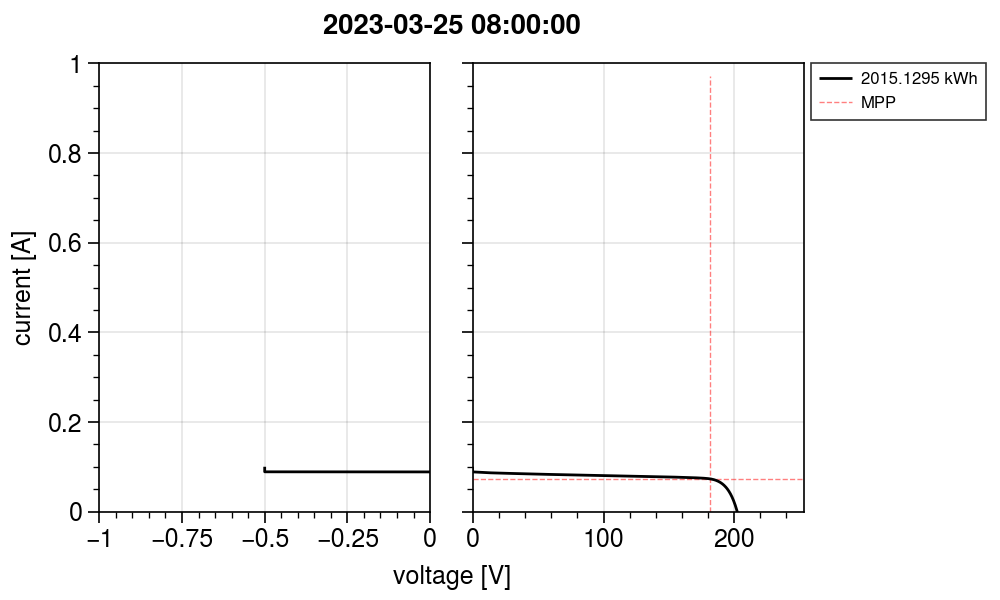

In [26]:
hoy = 2000

Gmod = po.get_dict_instance([surface,string,module_name])['YIELD']['initial_simulation']['irrad'][2000]
Imod = po.get_dict_instance([surface,string,module_name])['CURVES']['initial_simulation']['Imod'][hoy]
Vmod = po.get_dict_instance([surface,string,module_name])['CURVES']['initial_simulation']['Vmod'][hoy]

ipv_plots.plot_curves(Imod,
                      Vmod,
                      base_parameters,
                      y_max=1,
                      # labels=[str(t) for t in list(zip(Geff,Tcell))],
                      mpp=True,
                      x_min=-1,
                      labels=f"{Gmod / 1000} kWh",
                      title=time_utils.hoy_to_date(hoy))

1200